In [7]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [8]:
from scipy import stats
#r,p=stats.pearsonr(xdata,ydata)
#slope, intercept, r_value, p_value, std_err = stats.linregress(xdata,ydata)
from collections import defaultdict
import matplotlib.pyplot as plt

In [9]:
# A dictionary of movie reviewers and their ratings of a small set of movies
reviews={
    'Lisa Rose':
        {'Lady in the Water': 2.5, 'Snakes on a Plane': 3.5, 'Just My Luck': 3.0,
         'Superman Returns': 3.5, 'You, Me and Dupree': 2.5, 'The Night Listener': 3.0},
    'Gene Seymour':
        {'Lady in the Water': 3.0, 'Snakes on a Plane': 3.5, 'Just My Luck': 1.5,
         'Superman Returns': 5.0, 'The Night Listener': 3.0, 'You, Me and Dupree': 3.5}, 
    'Michael Phillips':
        {'Lady in the Water': 2.5, 'Snakes on a Plane': 3.0,
         'Superman Returns': 3.5, 'The Night Listener': 4.0},
    'Claudia Puig':
        {'Snakes on a Plane': 3.5, 'Just My Luck': 3.0, 'The Night Listener': 4.5,
         'Superman Returns': 4.0, 'You, Me and Dupree': 2.5},
    'Mick LaSalle':
         {'Lady in the Water': 3.0, 'Snakes on a Plane': 4.0, 'Just My Luck': 2.0,
          'Superman Returns': 3.0, 'The Night Listener': 3.0, 'You, Me and Dupree': 2.0}, 
    'Jack Matthews':
        {'Lady in the Water': 3.0, 'Snakes on a Plane': 4.0,
         'The Night Listener': 3.0, 'Superman Returns': 5.0, 'You, Me and Dupree': 3.5},
    'Toby':
        {'Snakes on a Plane':4.5,'You, Me and Dupree':1.0,'Superman Returns':4.0}
}

In [10]:
len(reviews), map(len,reviews.values())

(7, [5, 6, 5, 6, 3, 6, 4])

In [11]:
#what has Toby reviewed:
reviews['Toby']

{'Snakes on a Plane': 4.5, 'Superman Returns': 4.0, 'You, Me and Dupree': 1.0}

Jack Matthews: (3.5,4.0)
Mick LaSalle: (2.0,4.0)
Claudia Puig: (2.5,3.5)
Lisa Rose: (2.5,3.5)
Toby: (1.0,4.5)
Gene Seymour: (3.5,3.5)


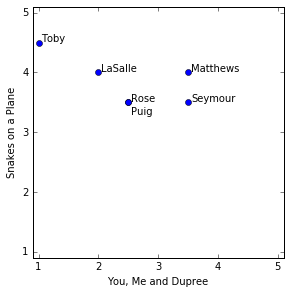

In [12]:
# plot the critics who reviewed these two:
dupree='You, Me and Dupree'
snakes='Snakes on a Plane'

crit2 = [critic for critic in reviews if dupree in reviews[critic] and snakes in reviews[critic]]
du_ratings=[reviews[c][dupree] for c in crit2]
sn_ratings=[reviews[c][snakes] for c in crit2]

plt.figure(figsize=(4.5,4.5))
xlim(.9,5.1),ylim(.9,5.1)
xlabel(dupree), ylabel(snakes)

plot(du_ratings,sn_ratings,'bo')

for crit,x,y in zip(crit2,du_ratings,sn_ratings):
    print '{}: ({},{})'.format(crit,x,y)
#move Puig down to avoid collision
    text(x+.05,y+(.01 if 'Puig' not in crit else -.2),crit.split()[-1])

Какие из критиков схожи по интересам? Основываясь только на два фильма, мы можем заключить, что Rose и Puig достаточно похожи, в то время как Toby сильно отличается от Seymour (на 2.5 балла по одному фильму и на 1 по другому). Расстояние между ними (Seymour и Toby) приблизительно равно $\sqrt{(3.5-1)^{2}+(3.5-4.5)^{2}}\approx 2.69$. В случае, когда у пары критиков более двух совпадающих оцененных фильмов, в формуле расстояния вычисляется корень из суммы квадратов разностей оценок по всем таким фильмам: $d_{i,j}^{2} = \sum_{m}(r_{m}(i)-r_{m}(j))^{2}$.

На практике удобно использовать меру сходства,а не расстояния (их зависимость обратно пропорциональна):$s_{i,j} = \frac{1}{1+d_{i,j}^{2}}$. $s_{i,j}$ лежит в отрезке $(0;1]$ (около 0, когда расстояние очень велико;  близко или равно 1 в случае небольшого или нулевого расстояния). Ниже sim_distance() возвращает оценку похожести для двух пользователей, учитывая только совпадающие для них оцененные объекты.

In [15]:
def sim_distance(prefs,person1,person2):
    # Get the list of shared_items
    shared_items=[item for item in prefs[person1] if item in prefs[person2]]

    # if they have no ratings in common, return 0
    if len(shared_items)==0: return 0

    v1=array([prefs[person1][item] for item in shared_items])
    v2=array([prefs[person2][item] for item in shared_items])

    # use numpy euclidean distance (sqrt(sum of squares))
    dist=norm(v1-v2)

    #transform to similarity ranging from 0 to 1
    #truncate to three after decimal point
    return 1/(1+dist**2)

Lisa Rose [ 2.5  2.5  3.   3.   3.5  3.5]
Gene Seymour [ 3.   3.5  1.5  3.   3.5  5. ]
Mick LaSalle [ 3.  2.  2.  3.  4.  3.]


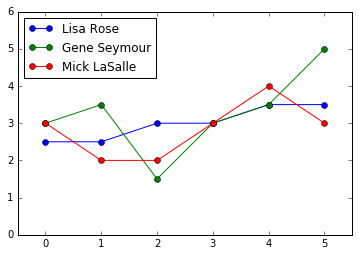

In [16]:
#'Lisa Rose' happened to rate all movies
all_movies = sorted(reviews['Lisa Rose'],key=reviews['Lisa Rose'].get)

def ratings(critic): return array([reviews[critic][m] for m in all_movies])

for crit in ('Lisa Rose','Gene Seymour','Mick LaSalle'):
    print crit,ratings(crit)
    plot(ratings(crit),'o-',label=crit)

ylim(0,6),xlim(-.5,5.5)
legend(loc='upper left');

In [17]:
#for example, the green and blue
round(sim_distance(reviews,'Lisa Rose','Gene Seymour'),3)

0.148

Рассмотрим отличную от предыдущей меру расстояния: корреляция Пирсона (+1, если коррелируют, -1, если антикоррелируют и промежуточные между +1 и -1 значения для шумных корреляций (noisy correlations)). Корреляция Пирсона определяется следующим образом:
$$\frac{E[X-E[X]]E[Y-E[Y]]}{\sigma_{X}\sigma_{Y}}$$

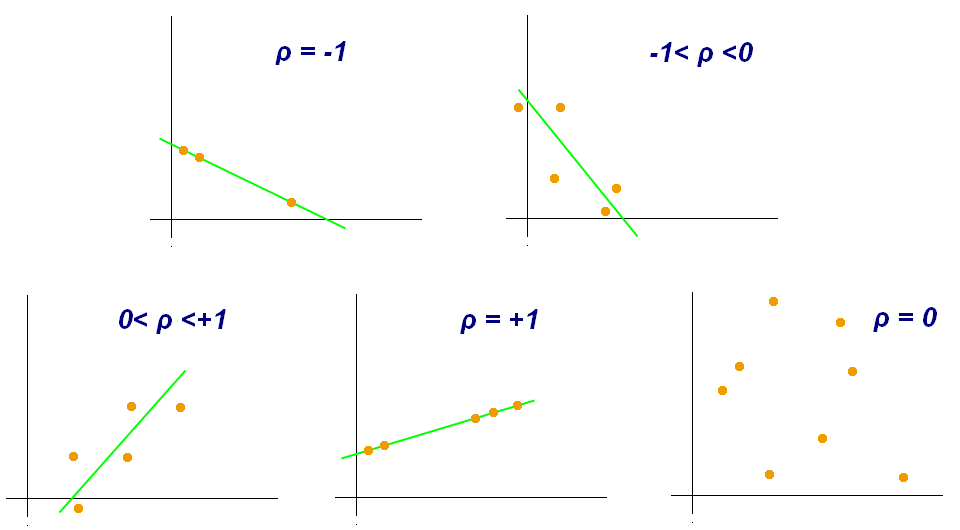

In [19]:
from IPython.display import Image
Image('Pearson.png',width=600)

In [20]:
#three critics who rated all 6
crit6 = [crit for crit in reviews if len(reviews[crit])==6]
#three pairs from above set
pairs = [(crit6[i],crit6[j]) for i in range(len(crit6)) for j in range(i)]

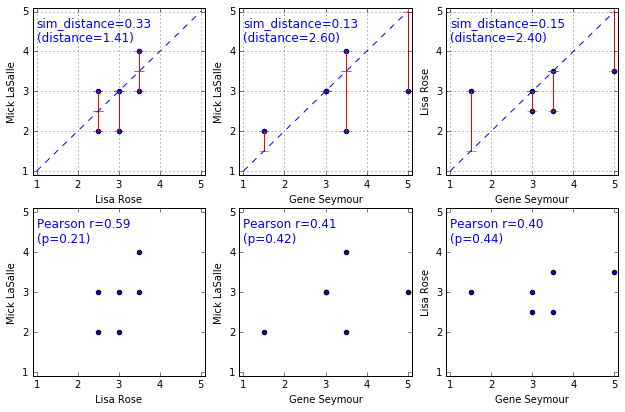

In [21]:
#compare the similarity based on distance with Pearson for these three pairs:

plt.figure(figsize=(10.5,6.6))
for j,(c1,c2) in enumerate(pairs):
    subplot(2,3,j+1)
    scatter(ratings(c1),ratings(c2))
    for (x,y) in zip(ratings(c1),ratings(c2)): plot((x,x),(x,y),'r-',marker='_',ms=10)        
    grid('on')
    xticks(range(1,6)),yticks(range(1,6))
    axis((.9,5.1,.9,5.1))
    xlabel(c1),ylabel(c2)
    plot((1,5),(1,5),'b--')
    d=norm(ratings(c1)-ratings(c2))
    text(1,4.25,'sim_distance={:.2f}\n(distance={:.2f})'.\
         format(sim_distance(reviews,c1,c2),d),fontsize=12,color='b')
        
    subplot(2,3,j+4)
    scatter(ratings(c1),ratings(c2))
    xticks(range(1,6)),yticks(range(1,6))
    axis((.9,5.1,.9,5.1))
    xlabel(c1),ylabel(c2)
    r,p=stats.pearsonr(ratings(c1),ratings(c2))
    text(1,4.25,'Pearson r={:.2f}\n(p={:.2f})'.format(r,p),fontsize=12,color='b')

In [22]:
#define function to look at the Pearson r for a few critic pairs

def show_pearson(prefs,crit1,crit2):
    shared_items=[item for item in prefs[crit1] if item in prefs[crit2]]

    figure(figsize=(5,5))
    xlim(.8,5.2),ylim(.8,5.2)
    xdata = [prefs[crit1][item] for item in shared_items]
    ydata = [prefs[crit2][item] for item in shared_items]

    slope, intercept, r_value, p_value, std_err = stats.linregress(xdata,ydata)
    xlabel(crit1),ylabel(crit2)
    
    plot(xdata,ydata,'o')
    plot(slope*arange(6)+intercept,'--')
    
    voffset={(x,y):.01 for x,y in zip(xdata,ydata)}
    for item in shared_items:
        x,y=prefs[crit1][item],prefs[crit2][item]
        text(x+.05, y+voffset[(x,y)], item)
        voffset[(x,y)]-=.15
    text(1.25,4.5,'Pearson r = {:.2f}'.format(r_value),fontsize=14,color='b')

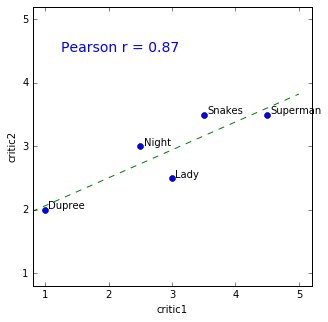

In [23]:
#two fake critics roughly correlated
fcritics={'critic1':{'Dupree':1,'Night':2.5,'Lady':3,'Snakes':3.5,'Superman':4.5},
         'critic2':{'Dupree':2,'Night':3,'Lady':2.5,'Snakes':3.5,'Superman':3.5}}
show_pearson(fcritics,'critic1','critic2')

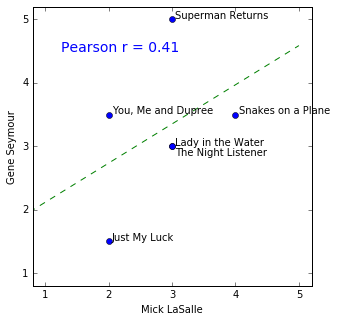

In [24]:
#two from original set not quite as well correlated
show_pearson(reviews,'Mick LaSalle','Gene Seymour')

In [25]:
#now define similarity measure, analogous to sim_distance
def sim_pearson(prefs,crit1,crit2):
    shared_items=[item for item in prefs[crit1] if item in prefs[crit2]]
  #  shared_items=list(set(prefs[person1]) & set(prefs[person2]))  #equivalent
    if len(shared_items)==0: return 0
    xdata = [prefs[crit1][item] for item in shared_items]
    ydata = [prefs[crit2][item] for item in shared_items]
    r,p=stats.pearsonr(xdata,ydata)
    if isnan(r): return 0
    return r

Теперь отранжируем критиков и найдем критика, наиболее схожего с данным (критики отранжированны согласно функции близости (similarity measure)).

In [26]:
# Returns the best matches for person from the prefs dictionary. 
# Number of results and similarity function are optional params.

def topMatches(prefs, person, n=5, similarity=sim_pearson):
  scores=[(other, round(similarity(prefs,person,other),3))
                  for other in prefs if other != person]
  return sorted(scores,key=lambda x:x[1],reverse=True)[:n]

In [27]:
topMatches(reviews,'Toby',6)

[('Lisa Rose', 0.991),
 ('Mick LaSalle', 0.924),
 ('Claudia Puig', 0.893),
 ('Jack Matthews', 0.663),
 ('Gene Seymour', 0.381),
 ('Michael Phillips', -1.0)]

In [28]:
# see how topmatches function works using other similarity measure
topMatches(reviews,'Toby', n=3, similarity=sim_distance)

[('Mick LaSalle', 0.308), ('Michael Phillips', 0.286), ('Claudia Puig', 0.235)]

Сейчас мы хотим сделать рекомендации. Для этого мы могли бы использовать наиболее похожего человека и выбрать фильмы,которые он смотрел, а человек,для которого проводятся рекомендации не смотрел. Но, возможно этот схожий человек не посмотрел наиболее релевантные фильмы или фильм,который мы хотим порекомендовать по его просмотрам является выбросом (нравится этому человеку, но не нравится всем остальным,которые также похожи на пользователя, для которого мы делаем рекомендации).

Поэтому для рекомендаций будем использовать средневзвешенную сумму рейтингов по всем пользователям, которые оценили данный фильм. Предположим, пользователь $i$  имеет оценку похожести $s_{i}$ к рассматриваемому пользователю и ставит рейтинг $r_{i}(m)$ фильму m, непросмотренному пользователем,для которого хотим сделать рекомендации. Т.о., похожий пользователь внесет вклад $s_{i}\cdot r_{i}(m)$ в предпочтения данного пользователя относительно фильма $m$. Итак, ожидаемый рейтинг фильма $m$ считается следующим образом:
$$E[r_{m}] = \frac{\sum_{i}s_{i}\cdot r_{i}(m)}{\sum_{i} s_{i}}$$

Ниже имплементирована представленная функция расчета ожидаемого рейтинга для всех фильмов, непросмотренных данным пользователем.

In [30]:
def getRecommendations(prefs,person,similarity=sim_pearson):
  totals={}
  simSums={}
  for other in prefs:
    # don't compare me to myself
    if other==person: continue
    sim=similarity(prefs,person,other)
    
    # ignore scores of zero or lower
    if sim<=0: continue
    for item in prefs[other]:

      # only score movies I haven't seen yet
      if item not in prefs[person] or prefs[person][item]==0:
        # Similarity * Score
        if item not in totals:
            totals[item]=0
            simSums[item]=0
        totals[item] += prefs[other][item]*sim
        # Sum of similarities
        simSums[item] += sim

  # Create the normalized list
  rankings=[(item,round(totals[item]/simSums[item],3)) for item in totals]

  # Return the sorted list
  return sorted(rankings,key=lambda x:x[1],reverse=True)

In [31]:
getRecommendations(reviews,'Toby')
#also gives likely rating

[('The Night Listener', 3.348),
 ('Lady in the Water', 2.833),
 ('Just My Luck', 2.531)]

In [32]:
#or use other distance measure
getRecommendations(reviews,'Toby',similarity=sim_distance)

[('The Night Listener', 3.5),
 ('Lady in the Water', 2.756),
 ('Just My Luck', 2.462)]

Теперь предположим, что мы хотим связывать объекты (например, на сайте Amazon (часто с этим продуктом пользователи также покупают...)). Поэтому вместо схожести пользователей мы будем рассматривать схожесть между объектами (предположение:различные пользователи стремятся оценить похожие объекты близкими рейтигами).

In [33]:
#first reverse role of items and objects
def transformPrefs(prefs):
  result=defaultdict(dict)
  for person in prefs:
    for item in prefs[person]:      
      # Flip item and person
      result[item][person]=prefs[person][item]
  return result

Используем это для получения оценки похожести между фильмами:

In [34]:
movies=transformPrefs(reviews)
movies

defaultdict(dict,
            {'Just My Luck': {'Claudia Puig': 3.0,
              'Gene Seymour': 1.5,
              'Lisa Rose': 3.0,
              'Mick LaSalle': 2.0},
             'Lady in the Water': {'Gene Seymour': 3.0,
              'Jack Matthews': 3.0,
              'Lisa Rose': 2.5,
              'Michael Phillips': 2.5,
              'Mick LaSalle': 3.0},
             'Snakes on a Plane': {'Claudia Puig': 3.5,
              'Gene Seymour': 3.5,
              'Jack Matthews': 4.0,
              'Lisa Rose': 3.5,
              'Michael Phillips': 3.0,
              'Mick LaSalle': 4.0,
              'Toby': 4.5},
             'Superman Returns': {'Claudia Puig': 4.0,
              'Gene Seymour': 5.0,
              'Jack Matthews': 5.0,
              'Lisa Rose': 3.5,
              'Michael Phillips': 3.5,
              'Mick LaSalle': 3.0,
              'Toby': 4.0},
             'The Night Listener': {'Claudia Puig': 4.5,
              'Gene Seymour': 3.0,
              'J

In [35]:
#now topmatches gives similar movies rather than similar reviewers
topMatches(movies,'Superman Returns')

[('You, Me and Dupree', 0.658),
 ('Lady in the Water', 0.488),
 ('Snakes on a Plane', 0.112),
 ('The Night Listener', -0.18),
 ('Just My Luck', -0.423)]

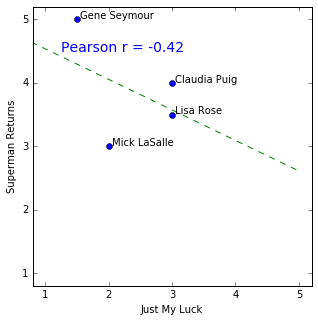

In [36]:
#note negative scores, reviewers who like one dislike the other
show_pearson(movies,'Just My Luck','Superman Returns')

Таким образом после смены ролей пользователей и фильмов, мы рекомендуем фильму пользователя (человека, который вероятно оценит этот фильм):

In [37]:
getRecommendations(movies,'Just My Luck')
#find critics for movie ... invite to premiere?

[('Michael Phillips', 4.0), ('Jack Matthews', 3.0)]